In [15]:
# !pip install torch-fidelity


In [16]:
# pip install torchmetrics scipy


In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import zipfile
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [17]:
# Function to unzip files
def unzip_files(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped {zip_path} to {extract_to}")

# Unzip the train and test files
unzip_files('/content/train.zip', '/content/train_data')
unzip_files('/content/test.zip', '/content/test_data')

Unzipped /content/train.zip to /content/train_data
Unzipped /content/test.zip to /content/test_data


In [19]:
base_path = '/content/train_data/train'

# Add full path column
train_df['image_path'] = train_df.apply(
    lambda row: os.path.join(base_path, row['label'], f"{row['photo_id']}.jpg"),
    axis=1
)

# Preview the new column
print(train_df[['photo_id', 'label', 'image_path']].head())


                 photo_id label  \
0  DtyK_6rTTJuKDm0J-QQ7zw  food   
1  ZrCKGuVZFg91nrhK-HykxA  food   
2  Rr_tlQiAi1jta9Y0PHn3vA  food   
3  mUaVBiAH54HVJ2WeVe2eeA  food   
4  xbdqUD_ly1tgtp0TQSJE9Q  food   

                                          image_path  
0  /content/train_data/train/food/DtyK_6rTTJuKDm0...  
1  /content/train_data/train/food/ZrCKGuVZFg91nrh...  
2  /content/train_data/train/food/Rr_tlQiAi1jta9Y...  
3  /content/train_data/train/food/mUaVBiAH54HVJ2W...  
4  /content/train_data/train/food/xbdqUD_ly1tgtp0...  


In [20]:
train_df.tail()

,photo_id,business_id,caption,label,image_path
70988,r06A1rPKKrIX_5AYtZ0l4Q,8V9G6dC9sLCGp1LQVrmXwA,NaN,outside,/content/train_data/train/outside/r06A1rPKKrIX...
70989,CUV8RP4_Ta2NrpP6yP_RPA,3nXWsbhF0YkxUX9cUtqewg,Rose Tree Park -- Christmas lights 2018,outside,/content/train_data/train/outside/CUV8RP4_Ta2N...
70990,4FEYk2h1q_gNQw9o8LZN3Q,DeY0JL4MpfKfB4jf2Bx68w,NaN,outside,/content/train_data/train/outside/4FEYk2h1q_gN...
70991,STGJ7HR9U84MTW4g0ceASg,ac1AeYqs8Z4_e2X5M3if2A,Great restaurant!,outside,/content/train_data/train/outside/STGJ7HR9U84M...
70992,3KNxaeBtV2JfX3HJlyjqjA,1LGyVebO0VzuaMiFjpH3bg,NaN,outside,/content/train_data/train/outside/3KNxaeBtV2Jf...


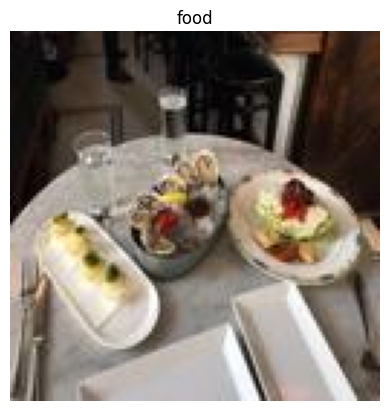

In [22]:
from PIL import Image
from matplotlib import pyplot as plt


sample_path = train_df['image_path'].iloc[0]
img = Image.open(sample_path)
plt.imshow(img)
plt.axis('off')
plt.title(train_df['label'].iloc[0])
plt.show()


In [26]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class YelpImageDataset(Dataset):
    def __init__(self, dataframe, image_size=128):
        self.df = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),  # Converts to [0, 1]
            transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
        ])
        self.label_map = {'food': 0, 'drink': 1, 'inside': 2, 'outside': 3}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label_str = self.df.iloc[idx]['label']
        label = self.label_map[label_str]

        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        return img, label


In [27]:
from torch.utils.data import DataLoader

# Create dataset
train_dataset = YelpImageDataset(train_df)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)


Batch shape: torch.Size([64, 3, 128, 128]), Labels: [2, 0, 0, 2, 1, 3, 0, 3]


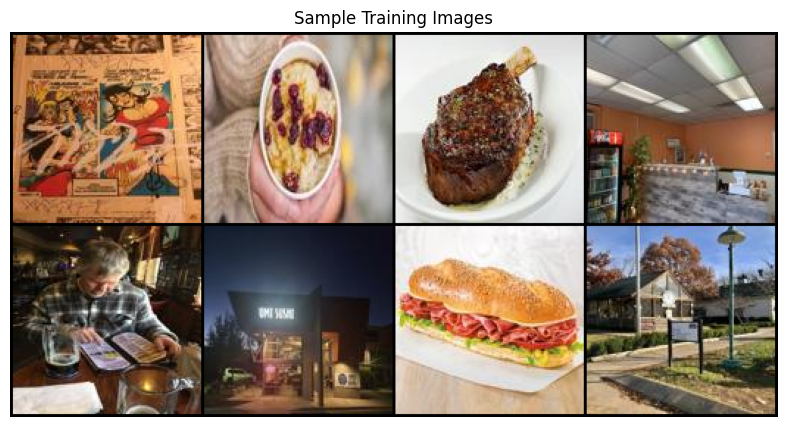

In [28]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:8].tolist()}")

# Show first 8 images
grid = vutils.make_grid(images[:8], nrow=4, normalize=True)
plt.figure(figsize=(10,5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Sample Training Images")
plt.show()


In [29]:
import torch.nn as nn
import torch

class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=4, img_channels=3, feature_dim=64):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)

        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, feature_dim * 8 * 4 * 4),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_dim * 8, 4, 4)),  # Shape: (B, 512, 4, 4)

            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1),  # 8×8
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1),  # 16×16
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, 2, 1),      # 32×32
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim, feature_dim // 2, 4, 2, 1),     # 64×64
            nn.BatchNorm2d(feature_dim // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim // 2, img_channels, 4, 2, 1),    # 128×128
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_emb(labels)
        x = torch.cat([noise, label_embed], dim=1)
        return self.model(x)


In [30]:
class Discriminator(nn.Module):
    def __init__(self, label_dim=4, img_channels=3, feature_dim=64):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)

        self.model = nn.Sequential(

            nn.Conv2d(img_channels + 1, feature_dim // 2, 4, 2, 1),  # 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim // 2, feature_dim, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1),   # 16x16
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1),  # 4x4
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(feature_dim * 8 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_map = label_embed.expand(-1, -1, images.size(2), images.size(3))
        x = torch.cat([images, label_map[:, 0:1, :, :]], dim=1)
        return self.model(x)


**Initialize Models and Optimizers**

In [31]:
noise_dim = 100
label_dim = 4
image_channels = 3
feature_dim = 64
lr = 2e-4
batch_size = 64

# Instantiate models
G = Generator(noise_dim, label_dim, image_channels, feature_dim).to(device)
D = Discriminator(label_dim, image_channels, feature_dim).to(device)

# Optimizers
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = torch.nn.BCELoss()


In [34]:
import torch
import torchvision.utils as vutils
import os


epochs = 20
sample_interval = 10


os.makedirs('cgan_outputs', exist_ok=True)

# Label names
label_names = ['food', 'drink', 'inside', 'outside']


fixed_noise = torch.randn(4, noise_dim, device=device)
fixed_labels = torch.tensor([0, 1, 2, 3], device=device)

for epoch in range(1, epochs + 1):
    for i, (real_imgs, labels) in enumerate(train_loader):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        real_validity = D(real_imgs, labels)
        real_targets = torch.ones_like(real_validity, device=device)

        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = G(z, labels)
        fake_validity = D(fake_imgs.detach(), labels)
        fake_targets = torch.zeros_like(fake_validity, device=device)

        d_loss_real = criterion(real_validity, real_targets)
        d_loss_fake = criterion(fake_validity, fake_targets)
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        gen_validity = D(fake_imgs, labels)
        g_loss = criterion(gen_validity, real_targets)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Logging
    print(f"Epoch [{epoch}/{epochs}] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

    # Save image samples every few epochs
    if epoch % sample_interval == 0 or epoch == epochs:
        G.eval()
        with torch.no_grad():
            fake_imgs = G(fixed_noise, fixed_labels)
            vutils.save_image(fake_imgs, f'cgan_outputs/epoch_{epoch}.png', nrow=4, normalize=True)
        G.train()


Epoch [1/20] | D_loss: 0.0480 | G_loss: 5.2023
Epoch [2/20] | D_loss: 0.6629 | G_loss: 1.8512
Epoch [3/20] | D_loss: 0.0667 | G_loss: 4.3477
Epoch [4/20] | D_loss: 0.0194 | G_loss: 5.3508
Epoch [5/20] | D_loss: 0.6881 | G_loss: 2.5747
Epoch [6/20] | D_loss: 0.5145 | G_loss: 10.6250
Epoch [7/20] | D_loss: 0.1475 | G_loss: 3.6639
Epoch [8/20] | D_loss: 0.0579 | G_loss: 3.9642
Epoch [9/20] | D_loss: 1.7745 | G_loss: 16.9301
Epoch [10/20] | D_loss: 0.0093 | G_loss: 6.0325
Epoch [11/20] | D_loss: 0.4268 | G_loss: 0.7834
Epoch [12/20] | D_loss: 0.4047 | G_loss: 5.6368
Epoch [13/20] | D_loss: 0.0292 | G_loss: 5.5243
Epoch [14/20] | D_loss: 0.0007 | G_loss: 8.5575
Epoch [15/20] | D_loss: 0.6992 | G_loss: 0.2265
Epoch [16/20] | D_loss: 0.5623 | G_loss: 0.9132
Epoch [17/20] | D_loss: 0.0908 | G_loss: 6.4391
Epoch [18/20] | D_loss: 0.2839 | G_loss: 7.5314
Epoch [19/20] | D_loss: 0.3286 | G_loss: 2.9744
Epoch [20/20] | D_loss: 0.1209 | G_loss: 3.8204


| Observation                                 | Interpretation                                              |
| ------------------------------------------- | ----------------------------------------------------------- |
| Fluctuating D_loss (0.0007 – 1.77)        | Discriminator is sometimes confident, sometimes confused    |
| G_loss varies a lot (0.2 – 16.9)          | Generator is sometimes fooling D, sometimes totally failing |
| Some very **low D\_loss + high G\_loss**    | D is overpowering G (G fails to fool D)                     |
| Some **very high G\_loss with low D\_loss** | G is learning aggressively or producing unrealistic samples |
| **No mode collapse** so far                 | Generator is producing varied outputs (good)                |


Discriminator is dominating for most of training (D_loss < 0.05 is too confident).

Generator struggles — high G_loss means it's not fooling D.

G_loss spiking to 15.9 in Epoch 16 could be due to gradient explosion or instability


Check Visually
Look at generated image samples at epochs 10, 15, and 20:

Do they change over epochs?

Are they clearly labeled (i.e., does label 0 really look like food and 1 like drink)?

Is there diversity, or do they all look similar?

How to Improve Stability
Training Tips:
Label Smoothing:

Use 0.9 instead of 1.0 for real targets in the discriminator:

python
Copy
Edit
real_targets = torch.full_like(real_validity, 0.9)
Feature Matching:

Change the generator loss to include a feature-based term to stabilize.

Smaller Learning Rate for D:

Reduce D's learning rate to prevent it from overpowering too quickly.

Gradient Penalty / WGAN:

Consider using a Wasserstein GAN with gradient penalty for more stable training.

One-sided label noise:

Occasionally flip real and fake labels in D’s training to prevent overconfidence.

**saving model checkpoints**

In [35]:
# torch.save(G.state_dict(), 'cgan_generator.pth')
# torch.save(D.state_dict(), 'cgan_discriminator.pth')


# Generating images

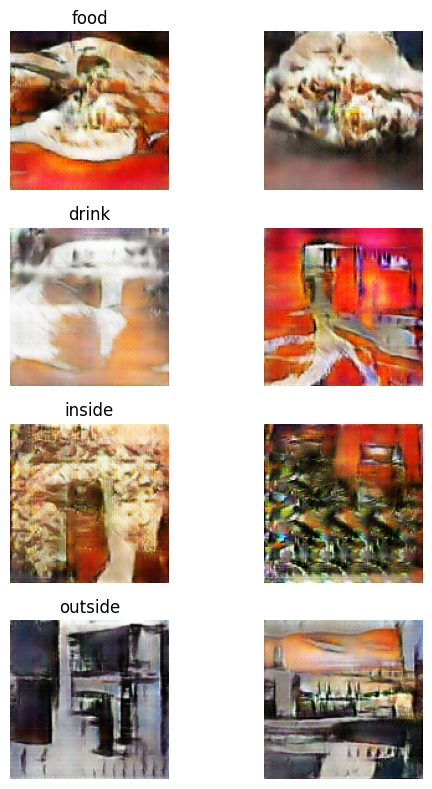

In [36]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

G.eval()
fig, axes = plt.subplots(len(label_names), 2, figsize=(6, 8))

with torch.no_grad():
    for row, label_id in enumerate(range(len(label_names))):
        for col in range(2):
            noise = torch.randn(1, noise_dim, device=device)
            label_tensor = torch.tensor([label_id], device=device)
            fake_img = G(noise, label_tensor)[0]  # shape: [3, H, W]

            # Convert tensor to PIL image for display
            img = TF.to_pil_image((fake_img + 1) / 2)  # unnormalize from [-1, 1] to [0, 1]

            axes[row, col].imshow(img)
            axes[row, col].axis('off')

            if col == 0:
                axes[row, col].set_title(label_names[label_id])

plt.tight_layout()
plt.show()



# Evaluation

Generating images labelwise

In [38]:
import torch
import torchvision.utils as vutils
import os

# Define label names (you can modify these based on your labels)
label_names = ['food', 'drink', 'inside', 'outside']

# Set the generator to evaluation mode
G.eval()

# Make sure output directories exist
os.makedirs('cgan_outputs_final/per_label', exist_ok=True)

with torch.no_grad():
    for label_id, label_name in enumerate(label_names):
        label_dir = f'cgan_outputs_final/per_label/{label_name}'
        os.makedirs(label_dir, exist_ok=True)

        # Generate 100 images per label
        for i in range(100):  # 100 images per label
            noise = torch.randn(1, noise_dim, device=device)
            label_tensor = torch.tensor([label_id], device=device)

            fake_img = G(noise, label_tensor)

            # Save the generated image
            save_path = os.path.join(label_dir, f'{label_name}_{i + 1}.png')
            vutils.save_image(fake_img, save_path, normalize=True)

# Set the generator back to training mode if needed
G.train()


Generator(
  (label_emb): Embedding(4, 4)
  (model): Sequential(
    (0): Linear(in_features=104, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [37]:
# import torch

# # Define the Generator and Discriminator classes (if not done already)

# # Initialize models
# G = Generator()  # Assuming your model architecture is defined
# D = Discriminator()

# # Load the saved model checkpoints
# G.load_state_dict(torch.load('cgan_generator.pth'))
# D.load_state_dict(torch.load('cgan_discriminator.pth'))

# # Set models to evaluation mode
# G.eval()
# D.eval()


In [39]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# Import FrechetInceptionDistance and InceptionScore explicitly
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to generated images
fake_dir = '/content/cgan_outputs_final/per_label'

# Path to real images (same label size and similar quantity)
real_dir = '/content/test_data/test'

# Transform to resize to 299x299 for InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Load real and fake image folders
real_dataset = ImageFolder(root=real_dir, transform=transform)
fake_dataset = ImageFolder(root=fake_dir, transform=transform)

real_loader = DataLoader(real_dataset, batch_size=16)
fake_loader = DataLoader(fake_dataset, batch_size=16)

# Calculate FID
fid = FrechetInceptionDistance(normalize=True).to(device)
for real, _ in real_loader:
    fid.update(real.to(device), real=True)
for fake, _ in fake_loader:
    fid.update(fake.to(device), real=False)

fid_score = fid.compute().item()

# Calculate Inception Score
# Concatenate all fake images into one tensor
all_fake_images = torch.cat([fake for fake, _ in fake_loader], dim=0).to(device)

# Convert the images to uint8 format (required by Inception Score)
all_fake_images = (all_fake_images * 255).clamp(0, 255).to(torch.uint8)

# Calculate Inception Score
inception = InceptionScore().to(device)
inception_score = inception(all_fake_images)[0].item()  # Get the mean score

print(f"FID Score: {fid_score:.4f}")
print(f"Inception Score: {inception_score:.4f}")


FID Score: 251.6553
Inception Score: 3.6319


Interpreting the Results:
FID Score: 251.65

The FID (Frechet Inception Distance) score compares the feature distributions of real and generated images.

Lower FID values indicate better performance: a value closer to 0 means the generated images are closer to real images in terms of feature space.

A high FID score (like 251.65) suggests that your generated images differ significantly from real images. This could indicate that the model is not generating realistic images, or the features extracted by InceptionV3 are not matching well between real and generated images.

Inception Score: 3.63

The Inception Score (IS) measures both quality and diversity of the generated images.

Higher IS values are better, and typically values between 5 and 10 are considered good for high-quality generative models.

An IS of 1.3037 is very low, suggesting that the generated images either lack quality or diversity. Your model might be generating images that are either hard to classify or are too similar to each other.

# Next steps
Model Improvement:

Try training the model for more epochs.


You can experiment with learning rates and other hyperparameters.

Data and Augmentation:

Consider increasing the dataset size or applying data augmentation to improve training.

Additional Metrics:

You might also want to explore visual inspection of generated images to manually assess their quality.

Perceptual Quality: Use human evaluation (if applicable) or qualitative metrics like IS and FID over multiple runs to see improvements.

In [41]:
# !zip -r cgan_outputs.zip cgan_outputs_final/

# Model Tuning

Discriminator is dominating for most of training (D_loss < 0.05 is too confident).

Generator struggles — high G_loss means it's not fooling D.

G_loss spiking to 15.9 in Epoch 16 could be due to gradient explosion or instability


Check Visually
Look at generated image samples at epochs 10, 15, and 20:

Do they change over epochs?

Are they clearly labeled (i.e., does label 0 really look like food and 1 like drink)?

Is there diversity, or do they all look similar?

🔧 How to Improve Stability
🧪 Training Tips:
Label Smoothing:

Use 0.9 instead of 1.0 for real targets in the discriminator:

python
Copy
Edit
real_targets = torch.full_like(real_validity, 0.9)
Feature Matching:

Change the generator loss to include a feature-based term to stabilize.

Smaller Learning Rate for D:

Reduce D's learning rate to prevent it from overpowering too quickly.

Gradient Penalty / WGAN:

Consider using a Wasserstein GAN with gradient penalty for more stable training.

One-sided label noise:

Occasionally flip real and fake labels in D’s training to prevent overconfidence.


based on above and evaluations,

tell me how to tune my model to improve performance

In [ ]:
!zip -r cgan_outputs.zip cgan_outputs/